<a href="https://colab.research.google.com/github/Achiever-caleb/Employee-Sentiment-and-Engagement-Analysis/blob/main/SP_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Data Wrangling

In [ ]:
df = pd.read_csv("/content/sp_test.csv")


In [ ]:
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [ ]:
df.isna().sum()

,0
Subject,0
body,0
date,0
from,0


In [ ]:
df.describe(include='all')

,Subject,body,date,from
count,2191,2191,2191,2191
unique,1251,1539,690,10
top,(No Subject),\n\n,7/1/2011,lydia.delgado@enron.com
freq,141,21,9,284


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


### Task 1: Sentiment Labeling

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
df['full_text'] = df['Subject'].fillna('') + " " + df['body'].fillna('')
df['sentiment'] = df['full_text'].apply(get_sentiment)

In [ ]:
df.head()

,Subject,body,date,from,full_text,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,Positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc,\n\nUnfortunately, today is ...",Positive
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham W...,Neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,Neutral
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,Positive


In [ ]:
df_new= df.drop(['Subject', 'body', 'date', 'from'], axis=1)

In [ ]:
df_new.head()

,full_text,sentiment
0,EnronOptions Update! EnronOptions Announcement...,Positive
1,"(No Subject) Marc,\n\nUnfortunately, today is ...",Positive
2,Phone Screen Interview - Shannon L. Burnham W...,Neutral
3,RE: My new work email we were thinking papasit...,Neutral
4,Bet Since you never gave me the $20 for the la...,Positive


In [ ]:
df_new.to_csv("labeled_dataset.csv", index=False)

###  Task 2: Exploratory Data Analysis (EDA)

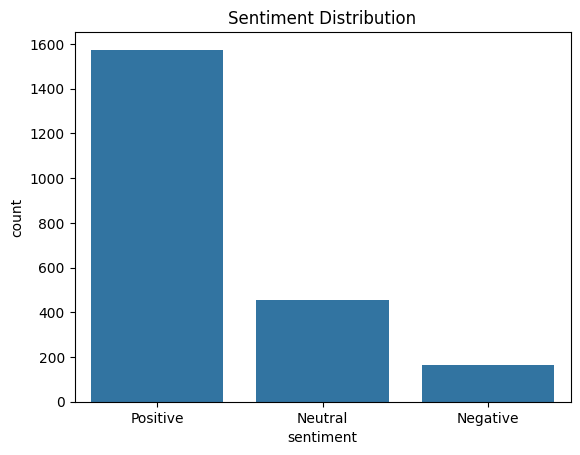

In [ ]:
# Distribution of sentiments
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.savefig('/content/countplot.png')

In [ ]:
# Time trend
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
monthly_sentiments = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)

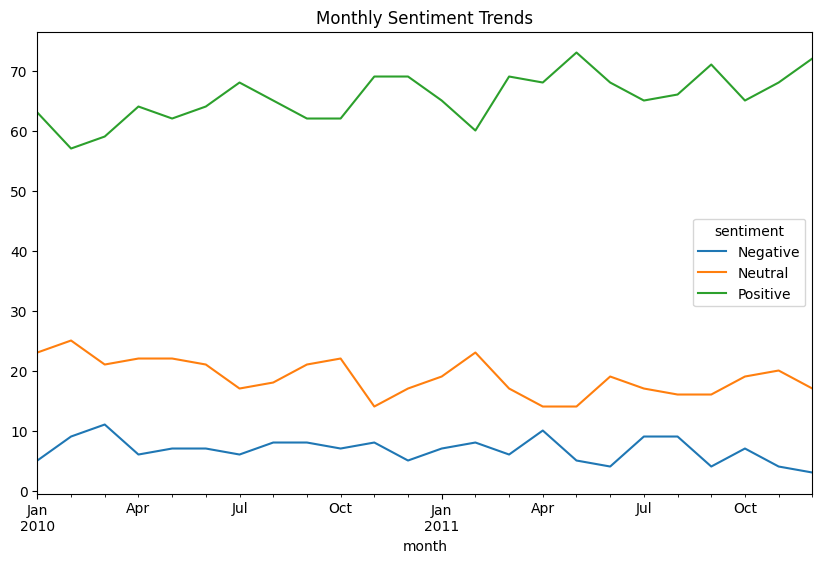

In [ ]:
monthly_sentiments.plot(kind='line', figsize=(10, 6))
plt.title("Monthly Sentiment Trends")
plt.savefig('/content/lineplot.png')

### Task 3: Employee Score Calculation

In [ ]:
sentiment_score = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['score'] = df['sentiment'].map(sentiment_score)


In [ ]:
# Monthly sentiment score
df['month'] = df['date'].dt.to_period('M')
monthly_scores = df.groupby(['from', 'month'])['score'].sum().reset_index()
monthly_scores.columns = ['employee', 'month', 'monthly_score']

In [ ]:
monthly_scores.head().sort_values(by='monthly_score', ascending=False)

,employee,month,monthly_score
1,bobette.riner@ipgdirect.com,2010-02,8
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,3
4,bobette.riner@ipgdirect.com,2010-05,3
0,bobette.riner@ipgdirect.com,2010-01,1


### Task 4: Employee Ranking

In [ ]:

# Top 3 Positive Employees (highest scores first, then alphabetical by name)
top_positive = monthly_scores.groupby('month').apply(
    lambda x: x.sort_values(['monthly_score', 'employee'], ascending=[False, True]).head(3)
).reset_index(drop=True)

# Top 3 Negative Employees (lowest/most negative scores first, then alphabetical by name)
top_negative = monthly_scores.groupby('month').apply(
    lambda x: x.sort_values(['monthly_score', 'employee'], ascending=[True, True]).head(3)
).reset_index(drop=True)


print("SUMMARY TABLES")


print("\nTop Positive Employees Summary:")
print(top_positive.to_string(index=False))

print("\nTop Negative Employees Summary:")
print(top_negative.to_string(index=False))

SUMMARY TABLES

Top Positive Employees Summary:
                   employee   month  monthly_score
    kayne.coulter@enron.com 2010-01             14
        eric.bass@enron.com 2010-01              9
    lydia.delgado@enron.com 2010-01              9
      john.arnold@enron.com 2010-02             12
    johnny.palmer@enron.com 2010-02             10
bobette.riner@ipgdirect.com 2010-02              8
       sally.beck@enron.com 2010-03             11
      john.arnold@enron.com 2010-03              7
        eric.bass@enron.com 2010-03              6
     don.baughman@enron.com 2010-04              9
    kayne.coulter@enron.com 2010-04              9
      john.arnold@enron.com 2010-04              8
     don.baughman@enron.com 2010-05             16
   patti.thompson@enron.com 2010-05              7
        eric.bass@enron.com 2010-05              6
     don.baughman@enron.com 2010-06             10
      john.arnold@enron.com 2010-06             10
   patti.thompson@enron.com 2010-0

### How the Rankings Are Determined:
For Positive Rankings:

- Sort by monthly_score in descending order (highest first)
- Then sort by employee name alphabetically (ascending)
- Take the top 3 results

For Negative Rankings:

- Sort by monthly_score in ascending order (lowest/most negative first)
- Then sort by employee name alphabetically (ascending)
- Take the top 3 results

### Task 5: Flight Risk Identification

In [ ]:
negatives = df[df['sentiment'] == 'Negative'][['from', 'date']]
negatives['date'] = pd.to_datetime(negatives['date'])
negatives = negatives.sort_values(['from', 'date'])

flight_risk = []

for employee, group in negatives.groupby('from'):
    dates = group['date'].tolist()
    for i in range(len(dates)):
        window = [d for d in dates if 0 <= (d - dates[i]).days <= 30]
        if len(window) >= 4:
            flight_risk.append(employee)
            break

flight_risk = list(set(flight_risk))

In [ ]:
flight_risk

['eric.bass@enron.com',
 'johnny.palmer@enron.com',
 'patti.thompson@enron.com',
 'bobette.riner@ipgdirect.com',
 'sally.beck@enron.com']

### Task 6: Predictive Modeling

In [ ]:
df['message_length'] = df['full_text'].apply(len)
monthly_features = df.groupby(['from', 'month']).agg(
    message_count=('full_text', 'count'),
    avg_length=('message_length', 'mean'),
    sentiment_score=('score', 'sum')
).reset_index()

# Modeling
X = monthly_features[['message_count', 'avg_length']]
y = monthly_features['sentiment_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.7130797143709661
RMSE: 1.8359780038565998
